## PyTimeTK - Time Series Analysis Package
pytimetk significantly simplifies the process of time series manipulation and visualization

### The 3 Core Properties of Time Series Data - 
Every time series DataFrame should have the following properties:

Time Series Index: A column containing ‘datetime64’ time stamps.

Value Columns: One or more columns containing numeric data that can be aggregated and visualized by time

Group Columns (Optional): One or more categorical or str columns that can be grouped by and time series can be evaluated by groups.

In [1]:
import pytimetk as tk
import pandas as pd
import polars as pl
import numpy as np
from pytimetk.utils.polars_helpers import pl_quantile
from pytimetk.utils.pandas_helpers import pd_quantile

df = tk.load_dataset('bike_sales_sample', parse_dates = ['order_date'])
df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 2466 rows of 13 columns
order_id:        int64             [1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5,  ...
order_line:      int64             [1, 2, 1, 2, 1, 2, 3, 4, 5, 1, 1, 2,  ...
order_date:      datetime64[ns]    [Timestamp('2011-01-07 00:00:00'), Ti ...
quantity:        int64             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,  ...
price:           int64             [6070, 5970, 2770, 5970, 10660, 3200, ...
total_price:     int64             [6070, 5970, 2770, 5970, 10660, 3200, ...
model:           object            ['Jekyll Carbon 2', 'Trigger Carbon 2 ...
category_1:      object            ['Mountain', 'Mountain', 'Mountain',  ...
category_2:      object            ['Over Mountain', 'Over Mountain', 'T ...
frame_material:  object            ['Carbon', 'Carbon', 'Aluminum', 'Car ...
bikeshop_name:   object            ['Ithaca Mountain Climbers', 'Ithaca  ...
city:            object            ['Ithaca', 'Ithaca', 'Kansas City', ' ...
state:       

### glimpse() method
GLimpse methos gives us a quick overview regarding the data like, the number of columns and rows present in the data, data types for each column and first initial values of the data for each column. This is similar to info() method in pandas but with more info regarding the data

### summarize_by_time() method
Summarize a DataFrame or GroupBy object by time and Perform Aggregations/cumulative sums easily

In [2]:
%%timeit
df.groupby(['category_1', 'frame_material']).summarize_by_time(date_column  = 'order_date', 
            value_column = ['total_price', 'quantity'], 
            freq         = 'MS',
            agg_func     = 'sum',
            wide_format  = False, 
            engine       = 'pandas'
        ).head()

35.7 ms ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
%%timeit
# Summarize by time with a GroupBy object (Wide Format), polars engine - Much Faster compared to pandas
df.groupby(['category_1', 'frame_material']).summarize_by_time(date_column  = 'order_date', 
            value_column = ['total_price', 'quantity'], 
            freq         = 'MS',
            agg_func     = 'sum',
            wide_format  = False, 
            engine       = 'polars'
        ).head()

30.4 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Compared to Pandas Engine Polaris Engine is much faster

In [4]:
# Summarize by time with a GroupBy object (Wide Format), polars engine - Much Faster compared to pandas
df.groupby(['category_1', 'frame_material']).summarize_by_time(date_column  = 'order_date', 
            value_column = ['total_price', 'quantity'], 
            freq         = 'MS',
            agg_func     = 'sum',
            wide_format  = False, 
            engine       = 'polars'
        ).head()

category_1 frame_material order_date  total_price_sum  quantity_sum
0   Mountain       Aluminum 2011-01-01            66290            34
1   Mountain       Aluminum 2011-02-01           245115           118
2   Mountain       Aluminum 2011-03-01            82025            41
3   Mountain       Aluminum 2011-04-01           340725           164
4   Mountain       Aluminum 2011-05-01           160130            93

In [5]:
sales_by_week_wide = df \
    .groupby('category_1') \
    .summarize_by_time(
        date_column = 'order_date',
        value_column = 'total_price',
        agg_func = ['sum'],
        freq = 'W',
        wide_format = True
    )

sales_by_week_wide.head()

order_date  total_price_sum_Mountain  total_price_sum_Road
0 2011-01-09                   12040.0                   0.0
1 2011-01-16                   82400.0               69060.0
2 2011-01-23                   28890.0              114960.0
3 2011-01-30                   98160.0               77505.0
4 2011-02-06                   37940.0               67270.0

In [6]:
# Summarize by time with a GroupBy object and multiple value columns and summaries (Wide Format)
# Note - This example only works with the pandas engine
df.groupby('category_1').summarize_by_time(
            date_column  = 'order_date', 
            value_column = ['total_price', 'quantity'], 
            freq         = 'MS',
            agg_func     = [
                'sum',
                'mean', 
                'median', 
                'min',
                ('q25', lambda x: np.quantile(x, 0.25)),
                ('q75', lambda x: np.quantile(x, 0.75)),
                'max',
                ('range',lambda x: x.max() - x.min()),
            ],
            wide_format  = False,
            engine       = 'pandas' 
        ).head()

category_1 order_date  total_price_sum  total_price_mean  \
0   Mountain 2011-01-01           221490       4922.000000   
1   Mountain 2011-02-01           660555       4374.536424   
2   Mountain 2011-03-01           358855       5882.868852   
3   Mountain 2011-04-01          1075975       4890.795455   
4   Mountain 2011-05-01           450440       4549.898990   

   total_price_median  total_price_min  total_price_q25  total_price_q75  \
0              3200.0              480           2060.0           6070.0   
1              3200.0              415           2060.0           5330.0   
2              3730.0              415           2130.0           6390.0   
3              3730.0              415           2060.0           5970.0   
4              3200.0              415           2010.0           6020.0   

   total_price_max  total_price_range  quantity_sum  quantity_mean  \
0            22380              21900            57       1.266667   
1            22380              21965           186       1.231788   
2            57400              56985            87       1.426230   
3            37300              36885           294       1.336364   
4            22380              21965           146       1.474747   

   quantity_median  quantity_min  quantity_q25  quantity_q75  quantity_max  \
0              1.0             1           1.0           1.0             4   
1              1.0             1           1.0           1.0             7   
2              1.0             1           1.0           1.0             7   
3              1.0             1           1.0           1.0            10   
4              1.0             1           1.0           1.0             6   

   quantity_range  
0               3  
1               6  
2               6  
3               9  
4               5

## Plot Timeseries

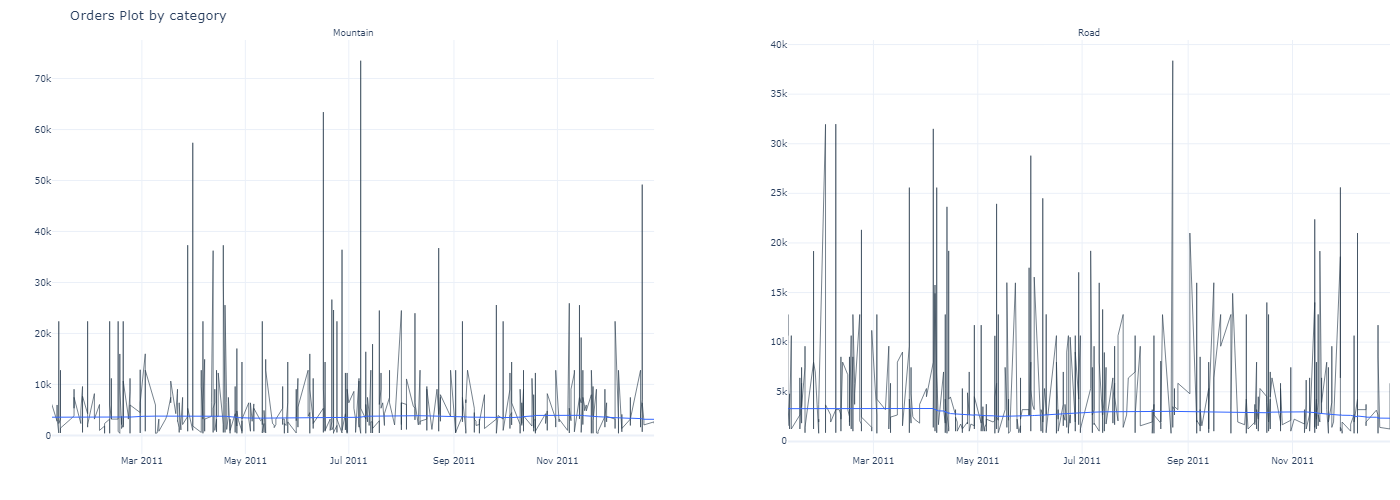

In [7]:
df.groupby('category_1').plot_timeseries(
            date_column  = 'order_date', 
            value_column = 'total_price', 
            facet_ncol = 2,
            width = 1200,
            height = 500,
            title="Orders Plot by category",
            engine="plotly"            
        )

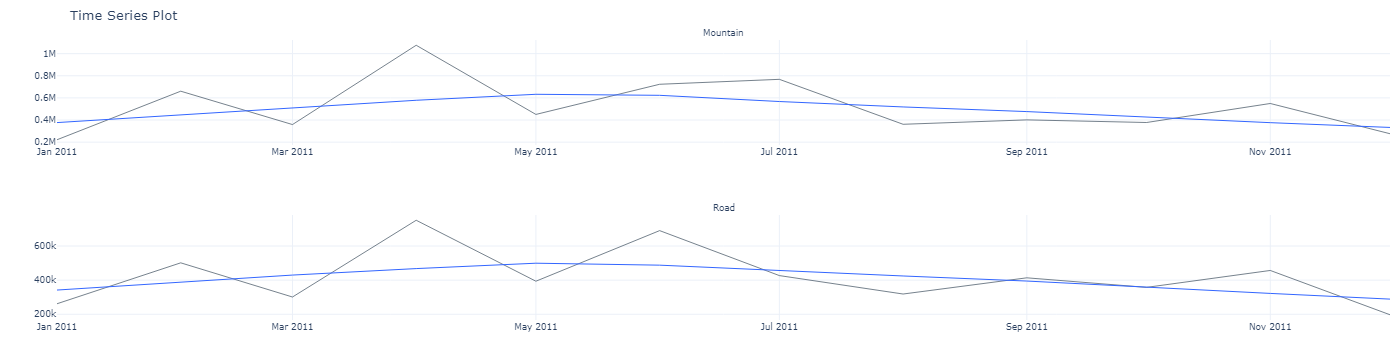

In [8]:
summary_category_1_df = df \
    .groupby("category_1") \
    .summarize_by_time(
        date_column  = 'order_date', 
        value_column = 'total_price',
        freq         = "MS",
        agg_func     = 'sum',
        wide_format  = False
    )

summary_category_1_df \
    .groupby('category_1') \
    .plot_timeseries(
        date_column  = 'order_date',
        value_column = 'total_price',
        smooth_frac  = 0.8
    )

In [9]:
# Get Weekly Totals by Group (Category 2)
sales_by_week = df \
    .groupby('category_2') \
    .summarize_by_time(
        date_column = 'order_date',
        value_column = 'total_price',
        agg_func = ['sum'],
        freq = 'W'
    )

sales_by_week.head()

category_2 order_date  total_price_sum
0  Cross Country Race 2011-01-16            61750
1  Cross Country Race 2011-01-23            25050
2  Cross Country Race 2011-01-30            56860
3  Cross Country Race 2011-02-06             8740
4  Cross Country Race 2011-02-13            78070

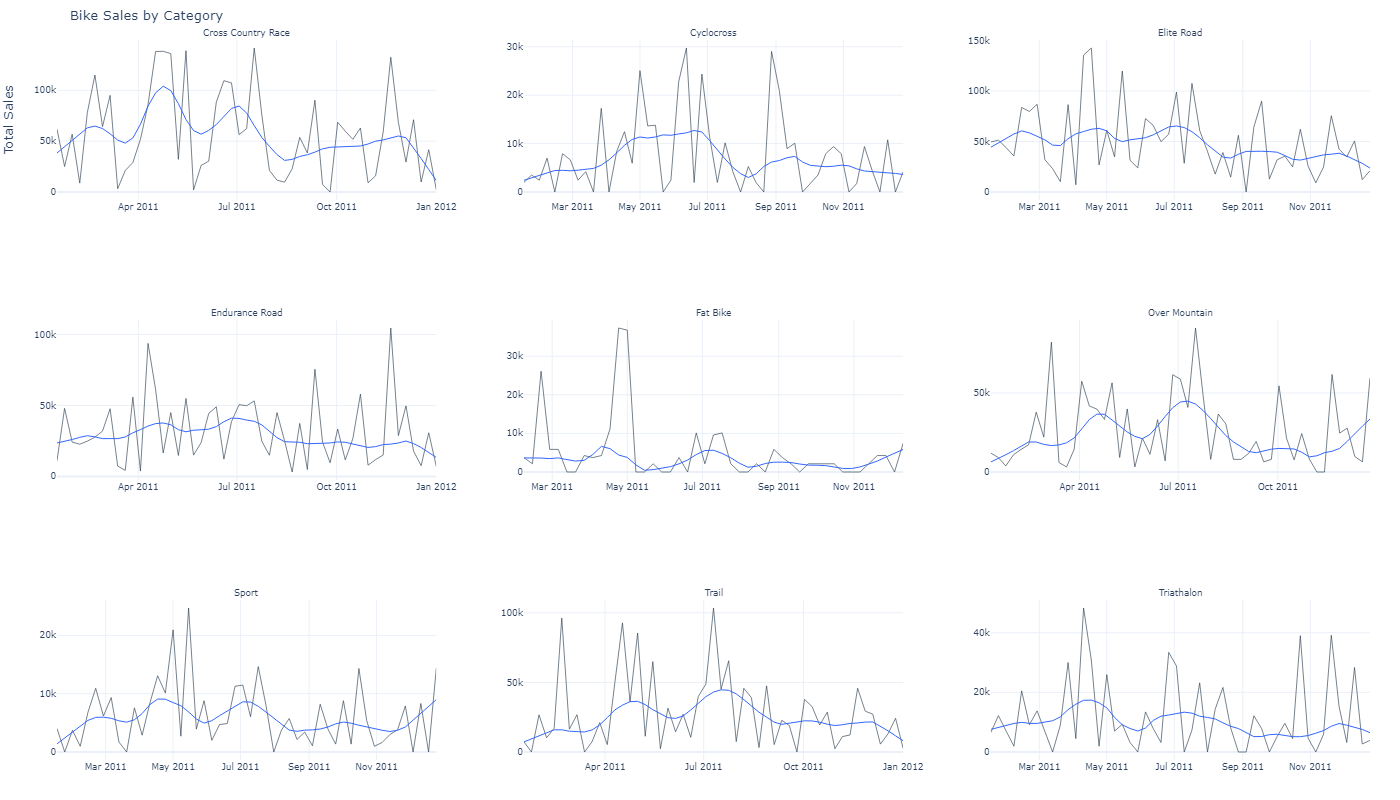

In [10]:
sales_by_week \
    .groupby('category_2') \
    .plot_timeseries(
        date_column = 'order_date',  
        value_column = 'total_price_sum',
        title = 'Bike Sales by Category',
        facet_ncol = 3,
        facet_scales = "free",
        y_intercept_color = tk.palette_timetk()['steel_blue'],
        width = 1000,
        height = 800,
        y_lab = 'Total Sales', 
        engine = 'plotly'
    )

The graph showcases a pronounced uptick in sales for most of the different bike products during the summer. It’s a natural trend, aligning with our understanding that people gravitate towards biking during the balmy summer days. Conversely, as the chill of winter sets in at the year’s start and end, we observe a corresponding dip in sales.

It’s worth highlighting the elegance of the plot_timeseries function. Beyond just plotting raw data, it introduces a smoother, accentuating underlying trends and making them more discernible. This enhancement ensures we can effortlessly capture and comprehend the cyclical nature of bike sales throughout the year.

### apply_by_time() method
Apply for time series.

In [11]:
# Apply by time with a GroupBy object. Allows access to multiple columns at once
( 
    df[['category_1', 'order_date', 'price', 'quantity']] 
        .groupby('category_1')
        .apply_by_time(
            
            # Named functions
            price_quantity_sum = lambda df: (df['price'] * df['quantity']).sum(),
            price_quantity_mean = lambda df: (df['price'] * df['quantity']).mean(),
            
            # Parameters
            date_column  = 'order_date', 
            freq         = "MS",
            
        )
).head()

category_1 order_date  price_quantity_sum  price_quantity_mean
0   Mountain 2011-01-01            221490.0               4920.0
1   Mountain 2011-02-01            660555.0               4376.0
2   Mountain 2011-03-01            358855.0               5884.0
3   Mountain 2011-04-01           1075975.0               4892.0
4   Mountain 2011-05-01            450440.0               4548.0

In [12]:
# Return complex objects
( 
    df[['order_date', 'price', 'quantity']] 
        .apply_by_time(
            
            # Named apply functions
            complex_object = lambda df: [df],
            
            # Parameters
            date_column  = 'order_date', 
            freq         = "MS",
            
        )
).head()

order_date                                              price  \
0 2011-01-01  [[6070, 5970, 2770, 5970, 10660, 3200, 12790, ...   
1 2011-02-01  [[8200, 7990, 3200, 4800, 3200, 2130, 1030, 37...   
2 2011-03-01  [[2660, 3200, 3200, 815, 8200, 9060, 815, 2130...   
3 2011-04-01  [[5330, 4500, 585, 2660, 3200, 2770, 1030, 234...   
4 2011-05-01  [[1840, 3200, 7000, 5860, 1030, 3200, 3500, 15...   

                                            quantity  
0  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,...  
1  [[1, 4, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 2,...  
2  [[1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,...  
3  [[1, 1, 1, 3, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 7,...  
4  [[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...

## Augument Timeseries

In [13]:
# Creating 29 engineered features from the date column
# Not run: help(tk.augment_timeseries_signature)
df_augmented = (
    df
        .augment_timeseries_signature(date_column = 'order_date')
)

df_augmented.head(1)

order_id  order_line order_date  quantity  price  total_price  \
0         1           1 2011-01-07         1   6070         6070   

             model category_1     category_2 frame_material  ...  \
0  Jekyll Carbon 2   Mountain  Over Mountain         Carbon  ...   

  order_date_mday order_date_qday order_date_yday  order_date_weekend  \
0               7               7               7                   0   

   order_date_hour  order_date_minute  order_date_second  order_date_msecond  \
0                0                  0                  0                   0   

   order_date_nsecond  order_date_am_pm  
0                   0                am  

[1 rows x 42 columns]

In [14]:
df_augmented.glimpse()

<class 'pandas.core.frame.DataFrame'>: 2466 rows of 42 columns
order_id:                 int64             [1, 1, 2, 2, 3, 3, 3, 3, 3,  ...
order_line:               int64             [1, 2, 1, 2, 1, 2, 3, 4, 5,  ...
order_date:               datetime64[ns]    [Timestamp('2011-01-07 00:00 ...
quantity:                 int64             [1, 1, 1, 1, 1, 1, 1, 1, 1,  ...
price:                    int64             [6070, 5970, 2770, 5970, 106 ...
total_price:              int64             [6070, 5970, 2770, 5970, 106 ...
model:                    object            ['Jekyll Carbon 2', 'Trigger ...
category_1:               object            ['Mountain', 'Mountain', 'Mo ...
category_2:               object            ['Over Mountain', 'Over Moun ...
frame_material:           object            ['Carbon', 'Carbon', 'Alumin ...
bikeshop_name:            object            ['Ithaca Mountain Climbers', ...
city:                     object            ['Ithaca', 'Ithaca', 'Kansas ...
state:       

### augument_expanding()
Apply one or more Series-based expanding functions to one or more columns of a DataFrame

In [15]:
# Example 1 - Pandas Backend for Expanding Window Functions
# This example demonstrates the use of string-named functions 
# on an expanding window using the Pandas backend for computations.
m4_daily = tk.load_dataset("m4_daily", parse_dates = ['date'])

expanded_df = (
    m4_daily
        .groupby('id')
        .augment_expanding(
            date_column = 'date', 
            value_column = 'value', 
            window_func = [
                'mean',  # Built-in mean function
                'std',   # Built-in standard deviation function,
                 ('quantile_75', lambda x: pd.Series(x).quantile(0.75)),  # Custom quantile function
                    
            ],
            min_periods = 1,
            engine = 'pandas',  # Utilize pandas for the underlying computations
            threads = 1,  # Disable parallel processing
            show_progress = True,  # Display a progress bar
            )
)
display(expanded_df.head())

Calculating Expanding...:   0%|          | 0/4 [00:00<?, ?it/s]

id       date   value  value_expanding_mean  value_expanding_std  \
0  D10 2014-07-03  2076.0                2076.0                  NaN   
1  D10 2014-07-04  2074.0                2076.0             1.414062   
2  D10 2014-07-05  2048.0                2066.0            15.617188   
3  D10 2014-07-06  2048.0                2062.0            15.609375   
4  D10 2014-07-07  2006.0                2050.0            28.265625   

   value_expanding_quantile_75  
0                       2076.0  
1                       2076.0  
2                       2076.0  
3                       2074.0  
4                       2074.0

In [16]:
# Example 2 - Polars Backend for Expanding Window Functions using Built-Ins 
#             (538X Faster than Pandas)
#  This example demonstrates the use of string-named functions and configurable functions using the Polars backend for computations. Configurable functions, like pl_quantile, allow the use 
# of specific parameters associated with their corresponding polars.Expr.rolling_<function_name> method. For instance, pl_quantile corresponds to polars.Expr.rolling_quantile.

expanded_df = (
    m4_daily
        .groupby('id')
        .augment_expanding(
            date_column = 'date', 
            value_column = 'value', 
            window_func = [
                'mean',  # Built-in mean function
                'std',   # Built-in std function
                ('quantile_75', pl_quantile(quantile=0.75)),  # Configurable with all parameters found in polars.Expr.rolling_quantile
            ],
            min_periods = 1,
            engine = 'polars',  # Utilize Polars for the underlying computations
        )
)
display(expanded_df.head())

id       date   value  value_expanding_mean  value_expanding_std  \
0  D10 2014-07-03  2076.0                2076.0             0.000000   
1  D10 2014-07-04  2074.0                2076.0             1.414062   
2  D10 2014-07-05  2048.0                2066.0            15.617188   
3  D10 2014-07-06  2048.0                2062.0            15.617188   
4  D10 2014-07-07  2006.0                2050.0            28.265625   

   value_expanding_quantile_75  
0                       2076.0  
1                       2076.0  
2                       2076.0  
3                       2076.0  
4                       2074.0

## Pandas Frequencies

In [17]:
# DataFrame with missing dates
import pandas as pd

data = {
    # '2023-09-05' is missing
    'datetime': ['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-06'],  
    'value': [10, 30, 40, 50, 60],
    'category':['b1','b1','b2','b2','b2']
}

df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['datetime'])
df

datetime  value category
0 2023-09-01     10       b1
1 2023-09-02     30       b1
2 2023-09-03     40       b2
3 2023-09-04     50       b2
4 2023-09-06     60       b2

In [18]:
df.pad_by_time('datetime', freq = '2D')

datetime  value category
0 2023-09-01   10.0       b1
1 2023-09-03   40.0       b2
2 2023-09-05    NaN      NaN

In [19]:
df.groupby('category').pad_by_time('datetime', freq = '2D')

datetime  value category
0 2023-09-01   10.0       b1
1 2023-09-03    NaN       b1
2 2023-09-05    NaN       b1
3 2023-09-01    NaN       b2
4 2023-09-03   40.0       b2
5 2023-09-05    NaN       b2

## Augumenting

In [20]:
# import libraries
import pytimetk as tk
import pandas as pd
import numpy as np
import random

# create sample data
dates = pd.date_range(start = '2023-09-18', end = '2023-09-24')
values = [random.randint(10, 50) for _ in range(7)]

df = pd.DataFrame({
    'date': dates,
    'value': values
})

df

date  value
0 2023-09-18     32
1 2023-09-19     30
2 2023-09-20     16
3 2023-09-21     22
4 2023-09-22     24
5 2023-09-23     47
6 2023-09-24     41

In [21]:
# augment lag
df \
    .augment_lags(
        date_column  = 'date',
        value_column = 'value',
        lags         = 3
    )

date  value  value_lag_3
0 2023-09-18     32          NaN
1 2023-09-19     30          NaN
2 2023-09-20     16          NaN
3 2023-09-21     22         32.0
4 2023-09-22     24         30.0
5 2023-09-23     47         16.0
6 2023-09-24     41         22.0

In [22]:
# augment leads
df \
    .augment_leads(
        date_column  = 'date',
        value_column = 'value',
        leads        = 3
    )

date  value  value_lead_3
0 2023-09-18     32          22.0
1 2023-09-19     30          24.0
2 2023-09-20     16          47.0
3 2023-09-21     22          41.0
4 2023-09-22     24           NaN
5 2023-09-23     47           NaN
6 2023-09-24     41           NaN

In [23]:
# load m4_daily_df
m4_daily_df = tk.load_dataset('m4_daily', parse_dates = ['date'])
# agument lags for grouped time series
m4_daily_df \
    .groupby("id") \
    .augment_lags(
        date_column  = 'date',
        value_column = 'value',
        lags         = (1, 7)
    )

id       date   value  value_lag_1  value_lag_2  value_lag_3  \
0      D10 2014-07-03  2076.0          NaN          NaN          NaN   
1      D10 2014-07-04  2074.0       2076.0          NaN          NaN   
2      D10 2014-07-05  2048.0       2074.0       2076.0          NaN   
3      D10 2014-07-06  2048.0       2048.0       2074.0       2076.0   
4      D10 2014-07-07  2006.0       2048.0       2048.0       2074.0   
...    ...        ...     ...          ...          ...          ...   
9738  D500 2012-09-19  9416.0       9432.0       9440.0       9472.0   
9739  D500 2012-09-20  9368.0       9416.0       9432.0       9440.0   
9740  D500 2012-09-21  9448.0       9368.0       9416.0       9432.0   
9741  D500 2012-09-22  9496.0       9448.0       9368.0       9416.0   
9742  D500 2012-09-23  9544.0       9496.0       9448.0       9368.0   

      value_lag_4  value_lag_5  value_lag_6  value_lag_7  
0             NaN          NaN          NaN          NaN  
1             NaN          NaN          NaN          NaN  
2             NaN          NaN          NaN          NaN  
3             NaN          NaN          NaN          NaN  
4          2076.0          NaN          NaN          NaN  
...           ...          ...          ...          ...  
9738       9360.0       9288.0       9264.0       9088.0  
9739       9472.0       9360.0       9288.0       9264.0  
9740       9440.0       9472.0       9360.0       9288.0  
9741       9432.0       9440.0       9472.0       9360.0  
9742       9416.0       9432.0       9440.0       9472.0  

[9743 rows x 10 columns]

In [24]:
# window = 3 days, window function = mean
df \
    .augment_rolling(
        date_column  = 'date',
        value_column = 'value',
        window       = 3,
        window_func  = 'mean'
    )

date  value  value_rolling_mean_win_3
0 2023-09-18     32                       NaN
1 2023-09-19     30                       NaN
2 2023-09-20     16                 26.000000
3 2023-09-21     22                 22.671875
4 2023-09-22     24                 20.671875
5 2023-09-23     47                 31.000000
6 2023-09-24     41                 37.343750

In [25]:
# agument rolling: center = false
df \
    .augment_rolling(
        date_column  = 'date',
        value_column = 'value',
        window       = 3,
        window_func  = 'mean',
        center       = True
    )

date  value  value_rolling_mean_win_3
0 2023-09-18     32                       NaN
1 2023-09-19     30                 26.000000
2 2023-09-20     16                 22.671875
3 2023-09-21     22                 20.671875
4 2023-09-22     24                 31.000000
5 2023-09-23     47                 37.343750
6 2023-09-24     41                       NaN

In [26]:
# augment rolling: window of 2 & 7 days, window_func of mean and standard deviation
m4_daily_df \
    .query('id == "D10"') \
    .augment_rolling(
                date_column = 'date',
                value_column = 'value',
                window = [2,7],
                window_func = ['mean', ('std', lambda x: x.std())]
            )

id       date   value  value_rolling_mean_win_2  \
0    D10 2014-07-03  2076.0                       NaN   
1    D10 2014-07-04  2074.0                    2076.0   
2    D10 2014-07-05  2048.0                    2060.0   
3    D10 2014-07-06  2048.0                    2048.0   
4    D10 2014-07-07  2006.0                    2027.0   
..   ...        ...     ...                       ...   
669  D10 2016-05-02  2630.0                    2616.0   
670  D10 2016-05-03  2650.0                    2640.0   
671  D10 2016-05-04  2632.0                    2640.0   
672  D10 2016-05-05  2622.0                    2628.0   
673  D10 2016-05-06  2620.0                    2620.0   

     value_rolling_std_win_2  value_rolling_mean_win_7  \
0                        NaN                       NaN   
1                        1.0                    2076.0   
2                       13.0                    2066.0   
3                        0.0                    2062.0   
4                       21.0                    2050.0   
..                       ...                       ...   
669                     15.0                    2580.0   
670                     10.0                    2594.0   
671                      9.0                    2602.0   
672                      5.0                    2608.0   
673                      1.0                    2618.0   

     value_rolling_std_win_7  
0                        NaN  
1                   1.000000  
2                  12.757812  
3                  13.515625  
4                  25.281250  
..                       ...  
669                28.625000  
670                33.187500  
671                35.312500  
672                34.781250  
673                23.375000  

[674 rows x 7 columns]

In [27]:
## augment rolling on grouped time series: window of 2 & 7 days, window_func of mean and standard deviation
m4_daily_df \
    .groupby('id') \
    .augment_rolling(
                date_column = 'date',
                value_column = 'value',
                window = [2,7],
                window_func = ['mean', ('std', lambda x: x.std())]
            )

Calculating Rolling...:   0%|          | 0/4 [00:00<?, ?it/s]

id       date   value  value_rolling_mean_win_2  \
0      D10 2014-07-03  2076.0                       NaN   
1      D10 2014-07-04  2074.0                    2076.0   
2      D10 2014-07-05  2048.0                    2060.0   
3      D10 2014-07-06  2048.0                    2048.0   
4      D10 2014-07-07  2006.0                    2027.0   
...    ...        ...     ...                       ...   
9738  D500 2012-09-19  9416.0                    9424.0   
9739  D500 2012-09-20  9368.0                    9392.0   
9740  D500 2012-09-21  9448.0                    9408.0   
9741  D500 2012-09-22  9496.0                    9472.0   
9742  D500 2012-09-23  9544.0                    9520.0   

      value_rolling_std_win_2  value_rolling_mean_win_7  \
0                         NaN                       NaN   
1                         1.0                    2076.0   
2                        13.0                    2066.0   
3                         0.0                    2062.0   
4                        21.0                    2050.0   
...                       ...                       ...   
9738                      8.0                    9384.0   
9739                     24.0                    9400.0   
9740                     40.0                    9416.0   
9741                     24.0                    9440.0   
9742                     24.0                    9448.0   

      value_rolling_std_win_7  
0                         NaN  
1                    1.000000  
2                   12.757812  
3                   13.515625  
4                   25.281250  
...                       ...  
9738                74.000000  
9739                57.500000  
9740                38.437500  
9741                37.875000  
9742                52.437500  

[9743 rows x 7 columns]

In [28]:
# create sample data
dates = pd.date_range(start = '2022-12-25', end = '2023-01-05')

df = pd.DataFrame({'date': dates})

# augment time series signature: USA
df \
    .augment_holiday_signature(
        date_column  = 'date',
        country_name = 'UnitedStates'
    )

date  is_holiday  before_holiday  after_holiday  \
0  2022-12-25           1               1              0   
1  2022-12-26           1               0              1   
2  2022-12-27           0               0              1   
3  2022-12-28           0               0              0   
4  2022-12-29           0               0              0   
5  2022-12-30           0               0              0   
6  2022-12-31           0               1              0   
7  2023-01-01           1               1              0   
8  2023-01-02           1               0              1   
9  2023-01-03           0               0              1   
10 2023-01-04           0               0              0   
11 2023-01-05           0               0              0   

                 holiday_name  
0               Christmas Day  
1    Christmas Day (Observed)  
2                         NaN  
3                         NaN  
4                         NaN  
5                         NaN  
6                         NaN  
7              New Year's Day  
8   New Year's Day (Observed)  
9                         NaN  
10                        NaN  
11                        NaN

`augment_fourier()` is used to add mutiple fourier series to time series data. Fourier transformation is often used as a feature engineering technique in time series forecasting as it helps detect hidden periodicities and cyclic patterns in the data. Capturing these hidden cyclic patterns can help improve predictive performance.

`augument_hilbert()` is used to apply the Hilbert transform to specified columns of a DataFrame or DataFrameGroupBy object.

`augument_wavelet()` is used to apply Wavely transform to specified columns of a DataFrame or DataFrameGroupBy object.

In [29]:
# augment fourier with 7 periods and max order of 1
m4_daily_df \
   .query('id == "D10"') \
   .augment_fourier(
      date_column  = 'date',
      value_column = 'value',
      num_periods  = 7,
      max_order    = 1
   ) \
  .head()

id       date   value  value_fourier_1_1  value_fourier_1_2  \
0  D10 2014-07-03  2076.0           0.000000           0.000000   
1  D10 2014-07-04  2074.0           0.980469          -0.387207   
2  D10 2014-07-05  2048.0          -0.387207           0.714355   
3  D10 2014-07-06  2048.0          -0.844238          -0.904785   
4  D10 2014-07-07  2006.0           0.714355           1.000000   

   value_fourier_1_3  value_fourier_1_4  value_fourier_1_5  value_fourier_1_6  \
0           0.000000           0.000000           0.000000           0.000000   
1          -0.844238           0.714355           0.518555          -0.904785   
2          -0.904785           1.000000          -0.886719           0.770996   
3          -0.000030           0.770996           0.981934           0.000060   
4           0.770996          -0.039856          -0.819336          -0.981934   

   value_fourier_1_7  
0           0.000000  
1          -0.208618  
2          -0.407959  
3          -0.770996  
4          -0.745117

In [30]:
walmart_sales_weekly = tk.load_dataset('walmart_sales_weekly', parse_dates=['Date'])
df_hilbert = (
    walmart_sales_weekly
        .groupby('id')
        .augment_hilbert(
            date_column = 'Date',
            value_column = ['Weekly_Sales'],
            engine = 'pandas'
        )
)

df_hilbert.head()

id  Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
0  1_1      1     1 2010-02-05  24924.500000          0    A  151315   
1  1_1      1     1 2010-02-12  46039.488281          1    A  151315   
2  1_1      1     1 2010-02-19  41595.550781          0    A  151315   
3  1_1      1     1 2010-02-26  19403.539062          0    A  151315   
4  1_1      1     1 2010-03-05  21827.900391          0    A  151315   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0      42.3125    2.572266        NaN        NaN        NaN        NaN   
1      38.5000    2.548828        NaN        NaN        NaN        NaN   
2      39.9375    2.513672        NaN        NaN        NaN        NaN   
3      46.6250    2.560547        NaN        NaN        NaN        NaN   
4      46.5000    2.625000        NaN        NaN        NaN        NaN   

   MarkDown5      CPI  Unemployment  Weekly_Sales_hilbert_real  \
0        NaN  211.125      8.109375               24924.500000   
1        NaN  211.250      8.109375               46039.488281   
2        NaN  211.250      8.109375               41595.550781   
3        NaN  211.375      8.109375               19403.539062   
4        NaN  211.375      8.109375               21827.900391   

   Weekly_Sales_hilbert_imag  
0                   -12768.0  
1                   -13472.0  
2                    16688.0  
3                     9376.0  
4                     2552.0

In [31]:
wavelet_df = (
    walmart_sales_weekly
        .groupby('id')
        .augment_wavelet(
            date_column = 'Date',
            value_column ='Weekly_Sales', 
            scales = [15],
            sample_rate =1,
            method = 'bump'
        )
    )
wavelet_df.head()

id  Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
0  1_1      1     1 2010-02-05  24924.500000          0    A  151315   
1  1_1      1     1 2010-02-12  46039.488281          1    A  151315   
2  1_1      1     1 2010-02-19  41595.550781          0    A  151315   
3  1_1      1     1 2010-02-26  19403.539062          0    A  151315   
4  1_1      1     1 2010-03-05  21827.900391          0    A  151315   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0      42.3125    2.572266        NaN        NaN        NaN        NaN   
1      38.5000    2.548828        NaN        NaN        NaN        NaN   
2      39.9375    2.513672        NaN        NaN        NaN        NaN   
3      46.6250    2.560547        NaN        NaN        NaN        NaN   
4      46.5000    2.625000        NaN        NaN        NaN        NaN   

   MarkDown5      CPI  Unemployment  bump_scale_15_real  bump_scale_15_imag  
0        NaN  211.125      8.109375        28340.714844                 0.0  
1        NaN  211.250      8.109375        32377.869141                 0.0  
2        NaN  211.250      8.109375        36178.125000                 0.0  
3        NaN  211.375      8.109375        39635.988281                 0.0  
4        NaN  211.375      8.109375        42668.585938                 0.0

## Sales Analysis

In [32]:
import pytimetk as tk
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [33]:
df = tk.datasets.load_dataset('bike_sales_sample')
df['order_date'] = pd.to_datetime(df['order_date'])

df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 2466 rows of 13 columns
order_id:        int64             [1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5,  ...
order_line:      int64             [1, 2, 1, 2, 1, 2, 3, 4, 5, 1, 1, 2,  ...
order_date:      datetime64[ns]    [Timestamp('2011-01-07 00:00:00'), Ti ...
quantity:        int64             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,  ...
price:           int64             [6070, 5970, 2770, 5970, 10660, 3200, ...
total_price:     int64             [6070, 5970, 2770, 5970, 10660, 3200, ...
model:           object            ['Jekyll Carbon 2', 'Trigger Carbon 2 ...
category_1:      object            ['Mountain', 'Mountain', 'Mountain',  ...
category_2:      object            ['Over Mountain', 'Over Mountain', 'T ...
frame_material:  object            ['Carbon', 'Carbon', 'Aluminum', 'Car ...
bikeshop_name:   object            ['Ithaca Mountain Climbers', 'Ithaca  ...
city:            object            ['Ithaca', 'Ithaca', 'Kansas City', ' ...
state:       

#### Getting Weekly Totals
We can quickly get totals by week with summarize_byt_time

In [34]:
weekly_totals = df.summarize_by_time(
    date_column  = 'order_date',
    value_column = 'total_price',
    agg_func     = ['sum'],
    freq         = 'W'
)

weekly_totals.head(10)

order_date  total_price_sum
0 2011-01-09            12040
1 2011-01-16           151460
2 2011-01-23           143850
3 2011-01-30           175665
4 2011-02-06           105210
5 2011-02-13           250390
6 2011-02-20           410595
7 2011-02-27           254045
8 2011-03-06           308420
9 2011-03-13            45450

#### Get Weekly Totals by Group (Category 2)
To better understand your data, you might want to add groups to this summary. We can include a groupby before the summarize_by_time and then aggregate our data.

In [35]:
 sales_by_week = df \
    .groupby('category_2') \
    .summarize_by_time(
        date_column = 'order_date',
        value_column = 'total_price',
        agg_func = ['sum'],
        freq = 'W'
    )

sales_by_week.head(10)

category_2 order_date  total_price_sum
0  Cross Country Race 2011-01-16            61750
1  Cross Country Race 2011-01-23            25050
2  Cross Country Race 2011-01-30            56860
3  Cross Country Race 2011-02-06             8740
4  Cross Country Race 2011-02-13            78070
5  Cross Country Race 2011-02-20           115010
6  Cross Country Race 2011-02-27            64290
7  Cross Country Race 2011-03-06            95070
8  Cross Country Race 2011-03-13             3200
9  Cross Country Race 2011-03-20            21170

#### Long vs Wide Format
This long format can make it a little hard to compare the different group values visually, so instead of long-format you might want to pivot wide to view the data.

In [36]:
sales_by_week_wide = df \
    .groupby('category_2') \
    .summarize_by_time(
        date_column = 'order_date',
        value_column = 'total_price',
        agg_func = ['sum'],
        freq = 'W',
        wide_format = True
    )

sales_by_week_wide.head(10)

order_date  total_price_sum_Cross Country Race  total_price_sum_Cyclocross  \
0 2011-01-09                                 0.0                         0.0   
1 2011-01-16                             61750.0                      1960.0   
2 2011-01-23                             25050.0                      3500.0   
3 2011-01-30                             56860.0                      2450.0   
4 2011-02-06                              8740.0                      7000.0   
5 2011-02-13                             78070.0                         0.0   
6 2011-02-20                            115010.0                      7910.0   
7 2011-02-27                             64290.0                      6650.0   
8 2011-03-06                             95070.0                      2450.0   
9 2011-03-13                              3200.0                      4200.0   

   total_price_sum_Elite Road  total_price_sum_Endurance Road  \
0                         0.0                             0.0   
1                     49540.0                         11110.0   
2                     51330.0                         47930.0   
3                     43895.0                         24160.0   
4                     35640.0                         22680.0   
5                     83780.0                         24820.0   
6                     79770.0                         27650.0   
7                     86900.0                         31900.0   
8                     31990.0                         47660.0   
9                     23110.0                          7260.0   

   total_price_sum_Fat Bike  total_price_sum_Over Mountain  \
0                       0.0                        12040.0   
1                       0.0                         9170.0   
2                       0.0                         3840.0   
3                       0.0                        10880.0   
4                    3730.0                        14270.0   
5                    2130.0                        17160.0   
6                   26100.0                        37830.0   
7                    5860.0                        22070.0   
8                    5860.0                        82060.0   
9                       0.0                         5970.0   

   total_price_sum_Sport  total_price_sum_Trail  total_price_sum_Triathalon  
0                    0.0                    0.0                         0.0  
1                 4030.0                 7450.0                      6450.0  
2                    0.0                    0.0                     12200.0  
3                 3720.0                26700.0                      7000.0  
4                  980.0                10220.0                      1950.0  
5                 6810.0                17120.0                     20500.0  
6                10925.0                96250.0                      9150.0  
7                 6165.0                16410.0                     13800.0  
8                 9340.0                26790.0                      7200.0  
9                 1710.0                    0.0                         0.0

You can now observe the total sales for each product side by side. This streamlined view facilitates easy comparison between product sales.

#### Visualize your time series data with tk.plot_timeseries
Visualize the summarized data to gain a clearer insight into the prevailing trends.

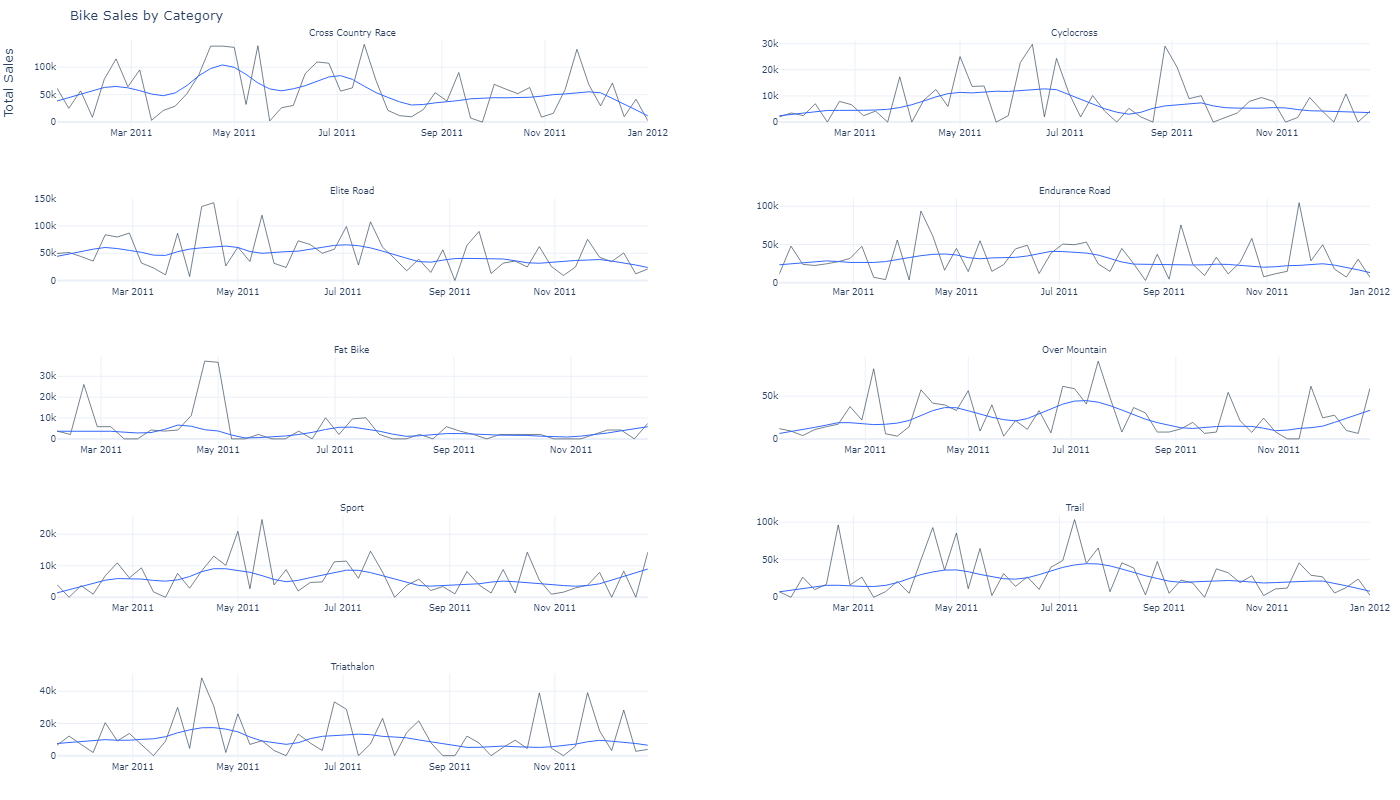

In [37]:
sales_by_week \
    .groupby('category_2') \
    .plot_timeseries(
        date_column = 'order_date',  
        value_column = 'total_price_sum',
        title = 'Bike Sales by Category',
        facet_ncol = 2,
        facet_scales = "free",
        y_intercept_color = tk.palette_timetk()['steel_blue'],
        width = 1000,
        height = 800,
        y_lab = 'Total Sales', 
        engine = 'plotly'
    )

The graph showcases a pronounced uptick in sales for most of the different bike products during the summer. It’s a natural trend, aligning with our understanding that people gravitate towards biking during the balmy summer days. Conversely, as the chill of winter sets in at the year’s start and end, we observe a corresponding dip in sales.

It’s worth highlighting the elegance of the plot_timeseries function. Beyond just plotting raw data, it introduces a smoother, accentuating underlying trends and making them more discernible. This enhancement ensures we can effortlessly capture and comprehend the cyclical nature of bike sales throughout the year.

### Create a Product Forecast Model
Forecasting future sales for bikes requires meticulous data preparation, and pytimetk streamlines this process for us. When crafting a Machine Learning model tailored for time series analysis, there are several pivotal steps to follow:

1.Time Padding for Comprehensive Historical Data: It’s essential to ensure that our data captures every week, even those that witnessed zero sales. This padding becomes especially pertinent when integrating time series features, like lags.

2.Crafting the Future Frame: This step involves setting up a structure that accommodates the test data features, which will eventually be fed into our prediction function.

3.Infusing Time Series Lag Features: These features are critical for capturing patterns in time series data, and they need to be integrated into our future frame.

4.Feature / Date Augmentation: This step can involve adding contextual features that might influence sales, such as date features, holidays, promotional events, etc.

5.Model Training: Once the data is prepped, it’s time to train our Machine Learning model, refining it to understand historical patterns and predict future trends.

6.Making Predictions: After training, the model is ready to forecast sales for future periods based on the features of the new data.

##### 1.Making irregular data regular with tk.pad_by_time

In [38]:
sales_padded = sales_by_week \
    .groupby('category_2') \
    .pad_by_time(
        date_column = 'order_date',
        freq        = 'W',
        end_date    = sales_by_week.order_date.max()
    )
sales_padded

category_2 order_date  total_price_sum
0    Cross Country Race 2011-01-09              NaN
1    Cross Country Race 2011-01-16          61750.0
2    Cross Country Race 2011-01-23          25050.0
3    Cross Country Race 2011-01-30          56860.0
4    Cross Country Race 2011-02-06           8740.0
..                  ...        ...              ...
463          Triathalon 2011-12-04           3200.0
464          Triathalon 2011-12-11          28350.0
465          Triathalon 2011-12-18           2700.0
466          Triathalon 2011-12-25           3900.0
467          Triathalon 2012-01-01              NaN

[468 rows x 3 columns]

##### 2.Making Future Dates Easier with tk.future_frame

In [39]:
df_with_futureframe = sales_padded \
    .groupby('category_2') \
    .future_frame(
        date_column = 'order_date',
        length_out  = 12
    )
df_with_futureframe

Future framing...:   0%|          | 0/9 [00:00<?, ?it/s]

category_2 order_date  total_price_sum
0    Cross Country Race 2011-01-09              NaN
1    Cross Country Race 2011-01-16          61750.0
2    Cross Country Race 2011-01-23          25050.0
3    Cross Country Race 2011-01-30          56860.0
4    Cross Country Race 2011-02-06           8740.0
..                  ...        ...              ...
571          Triathalon 2012-02-26              NaN
572          Triathalon 2012-03-04              NaN
573          Triathalon 2012-03-11              NaN
574          Triathalon 2012-03-18              NaN
575          Triathalon 2012-03-25              NaN

[576 rows x 3 columns]

##### 3.Lag Values with tk.augment_lags

In [40]:
df_with_lags = df_with_futureframe \
    .groupby('category_2') \
    .augment_lags(
        date_column  = 'order_date',
        value_column = 'total_price_sum',
        lags         = [12,24]

    )
df_with_lags.head(25)

category_2 order_date  total_price_sum  total_price_sum_lag_12  \
0   Cross Country Race 2011-01-09              NaN                     NaN   
1   Cross Country Race 2011-01-16          61750.0                     NaN   
2   Cross Country Race 2011-01-23          25050.0                     NaN   
3   Cross Country Race 2011-01-30          56860.0                     NaN   
4   Cross Country Race 2011-02-06           8740.0                     NaN   
5   Cross Country Race 2011-02-13          78070.0                     NaN   
6   Cross Country Race 2011-02-20         115010.0                     NaN   
7   Cross Country Race 2011-02-27          64290.0                     NaN   
8   Cross Country Race 2011-03-06          95070.0                     NaN   
9   Cross Country Race 2011-03-13           3200.0                     NaN   
10  Cross Country Race 2011-03-20          21170.0                     NaN   
11  Cross Country Race 2011-03-27          28990.0                     NaN   
12  Cross Country Race 2011-04-03          51860.0                     NaN   
13  Cross Country Race 2011-04-10          85910.0                 61750.0   
14  Cross Country Race 2011-04-17         138230.0                 25050.0   
15  Cross Country Race 2011-04-24         138350.0                 56860.0   
16  Cross Country Race 2011-05-01         136090.0                  8740.0   
17  Cross Country Race 2011-05-08          32110.0                 78070.0   
18  Cross Country Race 2011-05-15         139010.0                115010.0   
19  Cross Country Race 2011-05-22           2060.0                 64290.0   
20  Cross Country Race 2011-05-29          26130.0                 95070.0   
21  Cross Country Race 2011-06-05          30360.0                  3200.0   
22  Cross Country Race 2011-06-12          88280.0                 21170.0   
23  Cross Country Race 2011-06-19         109470.0                 28990.0   
24  Cross Country Race 2011-06-26         107280.0                 51860.0   

    total_price_sum_lag_24  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
5                      NaN  
6                      NaN  
7                      NaN  
8                      NaN  
9                      NaN  
10                     NaN  
11                     NaN  
12                     NaN  
13                     NaN  
14                     NaN  
15                     NaN  
16                     NaN  
17                     NaN  
18                     NaN  
19                     NaN  
20                     NaN  
21                     NaN  
22                     NaN  
23                     NaN  
24                     NaN

In [41]:
df_with_lags

category_2 order_date  total_price_sum  total_price_sum_lag_12  \
0    Cross Country Race 2011-01-09              NaN                     NaN   
1    Cross Country Race 2011-01-16          61750.0                     NaN   
2    Cross Country Race 2011-01-23          25050.0                     NaN   
3    Cross Country Race 2011-01-30          56860.0                     NaN   
4    Cross Country Race 2011-02-06           8740.0                     NaN   
..                  ...        ...              ...                     ...   
571          Triathalon 2012-02-26              NaN                  3200.0   
572          Triathalon 2012-03-04              NaN                 28350.0   
573          Triathalon 2012-03-11              NaN                  2700.0   
574          Triathalon 2012-03-18              NaN                  3900.0   
575          Triathalon 2012-03-25              NaN                     NaN   

     total_price_sum_lag_24  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
..                      ...  
571                 12150.0  
572                  7850.0  
573                     0.0  
574                  5150.0  
575                  9600.0  

[576 rows x 5 columns]

Discard the Affected Rows: This is a recommended approach if your dataset is sufficiently large. Removing a few initial rows might not significantly impact the training process.

Backfill Missing Values: In situations with limited data, you might consider backfilling these nulls using the first available values from lag 12 and 24. However, the appropriateness of this technique hinges on your specific context and objectives.

In [42]:
lag_columns = [col for col in df_with_lags.columns if 'lag' in col]
df_no_nas = df_with_lags \
    .dropna(subset=lag_columns, inplace=False)

df_no_nas.head()

category_2 order_date  total_price_sum  total_price_sum_lag_12  \
25  Cross Country Race 2011-07-03          56430.0                 85910.0   
26  Cross Country Race 2011-07-10          62320.0                138230.0   
27  Cross Country Race 2011-07-17         141620.0                138350.0   
28  Cross Country Race 2011-07-24          75720.0                136090.0   
29  Cross Country Race 2011-07-31          21240.0                 32110.0   

    total_price_sum_lag_24  
25                 61750.0  
26                 25050.0  
27                 56860.0  
28                  8740.0  
29                 78070.0

##### 4.Date Features with tk.augment_timeseries_signature

In [43]:
df_with_datefeatures = df_no_nas \
    .augment_timeseries_signature(date_column='order_date')

df_with_datefeatures.head(10)

category_2 order_date  total_price_sum  total_price_sum_lag_12  \
25  Cross Country Race 2011-07-03          56430.0                 85910.0   
26  Cross Country Race 2011-07-10          62320.0                138230.0   
27  Cross Country Race 2011-07-17         141620.0                138350.0   
28  Cross Country Race 2011-07-24          75720.0                136090.0   
29  Cross Country Race 2011-07-31          21240.0                 32110.0   
30  Cross Country Race 2011-08-07          11620.0                139010.0   
31  Cross Country Race 2011-08-14           9730.0                  2060.0   
32  Cross Country Race 2011-08-21          22780.0                 26130.0   
33  Cross Country Race 2011-08-28          53680.0                 30360.0   
34  Cross Country Race 2011-09-04          38360.0                 88280.0   

    total_price_sum_lag_24  order_date_index_num  order_date_year  \
25                 61750.0            1309651200             2011   
26                 25050.0            1310256000             2011   
27                 56860.0            1310860800             2011   
28                  8740.0            1311465600             2011   
29                 78070.0            1312070400             2011   
30                115010.0            1312675200             2011   
31                 64290.0            1313280000             2011   
32                 95070.0            1313884800             2011   
33                  3200.0            1314489600             2011   
34                 21170.0            1315094400             2011   

    order_date_year_iso  order_date_yearstart  order_date_yearend  ...  \
25                 2011                     0                   0  ...   
26                 2011                     0                   0  ...   
27                 2011                     0                   0  ...   
28                 2011                     0                   0  ...   
29                 2011                     0                   0  ...   
30                 2011                     0                   0  ...   
31                 2011                     0                   0  ...   
32                 2011                     0                   0  ...   
33                 2011                     0                   0  ...   
34                 2011                     0                   0  ...   

    order_date_mday  order_date_qday  order_date_yday order_date_weekend  \
25                3                3              184                  1   
26               10               10              191                  1   
27               17               17              198                  1   
28               24               24              205                  1   
29               31               31              212                  1   
30                7               38              219                  1   
31               14               45              226                  1   
32               21               52              233                  1   
33               28               59              240                  1   
34                4               66              247                  1   

    order_date_hour  order_date_minute  order_date_second order_date_msecond  \
25                0                  0                  0                  0   
26                0                  0                  0                  0   
27                0                  0                  0                  0   
28                0                  0                  0                  0   
29                0                  0                  0                  0   
30                0                  0                  0                  0   
31                0                  0                  0                  0   
32                0                  0                  0                  0   
33                0  

In [44]:
df_with_datefeatures_narrom = df_with_datefeatures[[
    'order_date', 
    'category_2', 
    'total_price_sum',
    'total_price_sum_lag_12',
    'total_price_sum_lag_24',
    'order_date_year',  
    'order_date_half', 
    'order_date_quarter',      
    'order_date_month',
    'order_date_yweek'
]]

df_with_datefeatures_narrom.glimpse()

<class 'pandas.core.frame.DataFrame'>: 341 rows of 10 columns
order_date:              datetime64[ns]    [Timestamp('2011-07-03 00:00: ...
category_2:              object            ['Cross Country Race', 'Cross ...
total_price_sum:         float32           [56430.0, 62320.0, 141620.0,  ...
total_price_sum_lag_12:  float32           [85910.0, 138230.0, 138350.0, ...
total_price_sum_lag_24:  float32           [61750.0, 25050.0, 56860.0, 8 ...
order_date_year:         int16             [2011, 2011, 2011, 2011, 2011 ...
order_date_half:         int8              [2, 2, 2, 2, 2, 2, 2, 2, 2, 2 ...
order_date_quarter:      int8              [3, 3, 3, 3, 3, 3, 3, 3, 3, 3 ...
order_date_month:        int8              [7, 7, 7, 7, 7, 8, 8, 8, 8, 9 ...
order_date_yweek:        UInt32            [26, 27, 28, 29, 30, 31, 32,  ...


In [45]:
# One Hot Encoding
df_encoded = pd.get_dummies(df_with_datefeatures_narrom, columns=['category_2'])

df_encoded.glimpse()

<class 'pandas.core.frame.DataFrame'>: 341 rows of 18 columns
order_date:                     datetime64[ns]    [Timestamp('2011-07-03 ...
total_price_sum:                float32           [56430.0, 62320.0, 141 ...
total_price_sum_lag_12:         float32           [85910.0, 138230.0, 13 ...
total_price_sum_lag_24:         float32           [61750.0, 25050.0, 568 ...
order_date_year:                int16             [2011, 2011, 2011, 201 ...
order_date_half:                int8              [2, 2, 2, 2, 2, 2, 2,  ...
order_date_quarter:             int8              [3, 3, 3, 3, 3, 3, 3,  ...
order_date_month:               int8              [7, 7, 7, 7, 7, 8, 8,  ...
order_date_yweek:               UInt32            [26, 27, 28, 29, 30, 3 ...
category_2_Cross Country Race:  uint8             [1, 1, 1, 1, 1, 1, 1,  ...
category_2_Cyclocross:          uint8             [0, 0, 0, 0, 0, 0, 0,  ...
category_2_Elite Road:          uint8             [0, 0, 0, 0, 0, 0, 0,  ...
category_2_End

##### Model Training

In [46]:
##### Training
future = df_encoded[df_encoded.total_price_sum.isnull()]
train = df_encoded[df_encoded.total_price_sum.notnull()]

In [47]:
train_columns = [ 'total_price_sum_lag_12',
       'total_price_sum_lag_24', 'order_date_year', 'order_date_half',
       'order_date_quarter', 'order_date_month', 'order_date_yweek','category_2_Cross Country Race', 'category_2_Cyclocross',
       'category_2_Elite Road', 'category_2_Endurance Road',
       'category_2_Fat Bike', 'category_2_Over Mountain', 'category_2_Sport',
       'category_2_Trail', 'category_2_Triathalon']
X = train[train_columns]
y = train[['total_price_sum']]

model = RandomForestRegressor(random_state=123)
model = model.fit(X, y)

#### Model Prediction

In [48]:
predicted_values = model.predict(future[train_columns])
future['y_pred'] = predicted_values

future.head()

order_date  total_price_sum  total_price_sum_lag_12  \
468 2012-01-08              NaN                 51820.0   
469 2012-01-15              NaN                 62940.0   
470 2012-01-22              NaN                  9060.0   
471 2012-01-29              NaN                 15980.0   
472 2012-02-05              NaN                 59180.0   

     total_price_sum_lag_24  order_date_year  order_date_half  \
468                 75720.0             2012                1   
469                 21240.0             2012                1   
470                 11620.0             2012                1   
471                  9730.0             2012                1   
472                 22780.0             2012                1   

     order_date_quarter  order_date_month  order_date_yweek  \
468                   1                 1                 1   
469                   1                 1                 2   
470                   1                 1                 3   
471                   1                 1                 4   
472                   1                 2                 5   

     category_2_Cross Country Race  category_2_Cyclocross  \
468                              1                      0   
469                              1                      0   
470                              1                      0   
471                              1                      0   
472                              1                      0   

     category_2_Elite Road  category_2_Endurance Road  category_2_Fat Bike  \
468                      0                          0                    0   
469                      0                          0                    0   
470                      0                          0                    0   
471                      0                          0                    0   
472                      0                          0                    0   

     category_2_Over Mountain  category_2_Sport  category_2_Trail  \
468                         0                 0                 0   
469                         0                 0                 0   
470                         0                 0                 0   
471                         0                 0                 0   
472                         0                 0                 0   

     category_2_Triathalon    y_pred  
468                      0  59462.00  
469                      0  59149.45  
470                      0  20458.40  
471                      0  31914.00  
472                      0  59128.95

In [49]:
train['type'] = 'actuals'
future['type'] = 'prediction'

full_df = pd.concat([train, future])

full_df.head()

order_date  total_price_sum  total_price_sum_lag_12  \
25 2011-07-03          56430.0                 85910.0   
26 2011-07-10          62320.0                138230.0   
27 2011-07-17         141620.0                138350.0   
28 2011-07-24          75720.0                136090.0   
29 2011-07-31          21240.0                 32110.0   

    total_price_sum_lag_24  order_date_year  order_date_half  \
25                 61750.0             2011                2   
26                 25050.0             2011                2   
27                 56860.0             2011                2   
28                  8740.0             2011                2   
29                 78070.0             2011                2   

    order_date_quarter  order_date_month  order_date_yweek  \
25                   3                 7                26   
26                   3                 7                27   
27                   3                 7                28   
28                   3                 7                29   
29                   3                 7                30   

    category_2_Cross Country Race  category_2_Cyclocross  \
25                              1                      0   
26                              1                      0   
27                              1                      0   
28                              1                      0   
29                              1                      0   

    category_2_Elite Road  category_2_Endurance Road  category_2_Fat Bike  \
25                      0                          0                    0   
26                      0                          0                    0   
27                      0                          0                    0   
28                      0                          0                    0   
29                      0                          0                    0   

    category_2_Over Mountain  category_2_Sport  category_2_Trail  \
25                         0                 0                 0   
26                         0                 0                 0   
27                         0                 0                 0   
28                         0                 0                 0   
29                         0                 0                 0   

    category_2_Triathalon     type  y_pred  
25                      0  actuals     NaN  
26                      0  actuals     NaN  
27                      0  actuals     NaN  
28                      0  actuals     NaN  
29                      0  actuals     NaN

In [50]:
# Extract dummy columns
dummy_cols = [col for col in full_df.columns if 'category' in col.lower() ]
full_df_reverted = full_df.copy()

# Convert dummy columns back to categorical column
full_df_reverted['category'] = full_df_reverted[dummy_cols].idxmax(axis=1).str.replace("A_", "")

# Drop dummy columns
full_df_reverted = full_df_reverted.drop(columns=dummy_cols)

full_df_reverted.head()

order_date  total_price_sum  total_price_sum_lag_12  \
25 2011-07-03          56430.0                 85910.0   
26 2011-07-10          62320.0                138230.0   
27 2011-07-17         141620.0                138350.0   
28 2011-07-24          75720.0                136090.0   
29 2011-07-31          21240.0                 32110.0   

    total_price_sum_lag_24  order_date_year  order_date_half  \
25                 61750.0             2011                2   
26                 25050.0             2011                2   
27                 56860.0             2011                2   
28                  8740.0             2011                2   
29                 78070.0             2011                2   

    order_date_quarter  order_date_month  order_date_yweek     type  y_pred  \
25                   3                 7                26  actuals     NaN   
26                   3                 7                27  actuals     NaN   
27                   3                 7                28  actuals     NaN   
28                   3                 7                29  actuals     NaN   
29                   3                 7                30  actuals     NaN   

                         category  
25  category_2_Cross Country Race  
26  category_2_Cross Country Race  
27  category_2_Cross Country Race  
28  category_2_Cross Country Race  
29  category_2_Cross Country Race

In [51]:
full_df_reverted['total_price_sum'] = np.where(full_df_reverted.type =='actuals', full_df_reverted.total_price_sum, full_df_reverted.y_pred)

full_df_reverted.head()

order_date  total_price_sum  total_price_sum_lag_12  \
25 2011-07-03          56430.0                 85910.0   
26 2011-07-10          62320.0                138230.0   
27 2011-07-17         141620.0                138350.0   
28 2011-07-24          75720.0                136090.0   
29 2011-07-31          21240.0                 32110.0   

    total_price_sum_lag_24  order_date_year  order_date_half  \
25                 61750.0             2011                2   
26                 25050.0             2011                2   
27                 56860.0             2011                2   
28                  8740.0             2011                2   
29                 78070.0             2011                2   

    order_date_quarter  order_date_month  order_date_yweek     type  y_pred  \
25                   3                 7                26  actuals     NaN   
26                   3                 7                27  actuals     NaN   
27                   3                 7                28  actuals     NaN   
28                   3                 7                29  actuals     NaN   
29                   3                 7                30  actuals     NaN   

                         category  
25  category_2_Cross Country Race  
26  category_2_Cross Country Race  
27  category_2_Cross Country Race  
28  category_2_Cross Country Race  
29  category_2_Cross Country Race

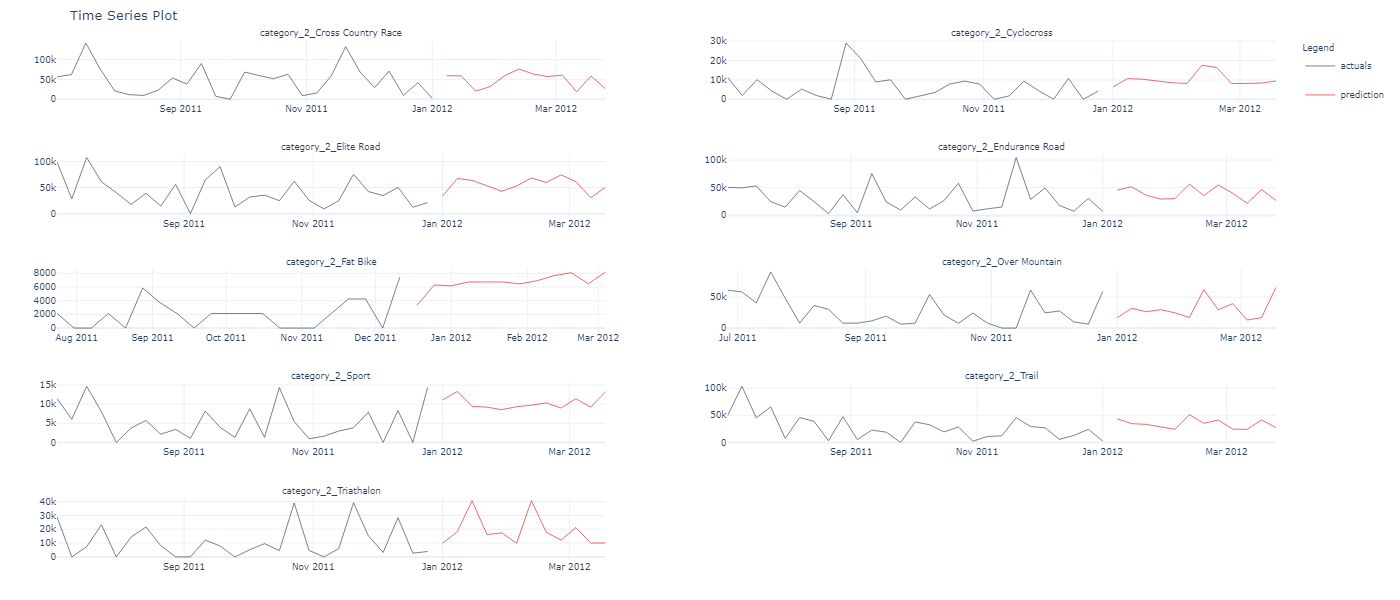

In [52]:
full_df_reverted \
    .groupby('category') \
    .plot_timeseries(
        date_column = 'order_date',
        value_column = 'total_price_sum',
        color_column = 'type',
        smooth = False,
        smooth_alpha = 0,
        facet_ncol = 2,
        facet_scales = "free",
        y_intercept_color = tk.palette_timetk()['steel_blue'],
        width = 800,
        height = 600,
        engine = 'plotly'
    )

This was a great example of how pytimetk can help Data Analysts and Data Scientists examine sales patterns from Customer Relationship Management (CRM) Databases.

We examined ways to wrangle complex transactional data with tk.summarize_by_time
We discovered how to visualize customer and product data with tk.plot_timeseries
We used tk.pad_by_time and tk.future_frame to prepare data for modeling
And, we learned how to add many features with augment functions including tk.augment_timeseries_signature ant tk.agument_lags
All of these pytimetk skills and techniques were necessary to produce a good sales forecast with sklearn.